# Count Vectorizer Feature Extraction and Model Training

This notebook performs Count Vectorizer feature extraction and trains multiple machine learning models for fake news detection.

## Overview
- Load preprocessed training data
- Optimize n-gram range using GridSearchCV
- Extract Count Vectorizer features
- Apply SMOTE for class balancing
- Train and evaluate multiple classifiers
- Generate performance visualizations and comparisons


## 1. Import Required Libraries


In [2]:
import pandas as pd
import numpy as np

## 2. Load Preprocessed Training Data

Load the training dataset that has been cleaned and preprocessed in the data_cleaning notebook.


In [3]:
df = pd.read_csv("data/processed/train.csv", converters={'tokens': eval})

## 3. Optimize N-gram Range

Use GridSearchCV to find the optimal n-gram range (unigrams, bigrams, trigrams) for Count Vectorizer feature extraction.


In [4]:
from sklearn.feature_extraction.text import CountVectorizer

# Set max_features for CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

# Define features and labels
X = df['clean_text'].values
y = df['label'].values  # Ensure your label column is correct

# Build pipeline using CountVectorizer
pipeline = Pipeline([
    ('count', CountVectorizer(stop_words='english')),
    ('clf', LogisticRegression(max_iter=1000))
])

# Set vocabulary size (optional but recommended)
pipeline.named_steps['count'].set_params(max_features=10000)

# Define parameter grid for N-gram testing
param_grid = {
    'count__ngram_range': [(1,1), (1,2), (1,3)]
}

# Use stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search to find the best N-gram range
grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

# Fit the model
grid.fit(X, y)

# Print results
print("Best N-gram range:", grid.best_params_['count__ngram_range'])
print("Best Accuracy score:", grid.best_score_)


Best N-gram range: (1, 2)
Best Accuracy score: 0.9956289085185356


In [15]:
from sklearn.feature_extraction.text import CountVectorizer
import pickle

# Apply CountVectorizer feature engineering with ngram_range (1,2) and max_features=10000
count_vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 2), max_features=10000)
count_features = count_vectorizer.fit_transform(df['clean_text'].values)

# Save the Count matrix and the vectorizer as a tuple to pickle file
with open('count_features_ngram.pkl', 'wb') as f:
    pickle.dump((count_features, count_vectorizer), f)


In [4]:
import pickle

with open('/home/root495/Inexture/Fake New Detection/count_features_ngram.pkl', 'rb') as f:
    count_features, count_vectorizer = pickle.load(f)


## SMOTE oversampling

In [5]:
from imblearn.over_sampling import SMOTE

# Use the same X and y as above
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(count_features, df['label'].values)

print("Class distribution after SMOTE:", dict(zip(*np.unique(y_res, return_counts=True))))


Class distribution after SMOTE: {0: 18771, 1: 18771}


## Load test data


In [6]:
import pandas as pd

# Load test data
test_df = pd.read_csv("data/processed/test.csv")

# Transform test data into TF-IDF representation using the fitted vectorizer
X_test = count_vectorizer.transform(test_df['clean_text'].values)
y_test = test_df["label"].values


## 9. Logistic Regression - Hyper Parameters and Model Evaluation

Train Logistic Regression with best hyperparameters and evaluate on test data.


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score, roc_auc_score

# Train logistic regression with default parameters
logreg_default = LogisticRegression()
logreg_default.fit(X_res, y_res)

# Predict on the test set
y_pred_default = logreg_default.predict(X_test)
y_proba_default = logreg_default.predict_proba(X_test)[:, 1]

# Calculate metrics
precision = precision_score(y_test, y_pred_default)
accuracy = accuracy_score(y_test, y_pred_default)
f1 = f1_score(y_test, y_pred_default)
recall = recall_score(y_test, y_pred_default)
roc_auc = roc_auc_score(y_test, y_proba_default)

print("Logistic Regression (default params) on test data:")
print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"ROC-AUC: {roc_auc}")


Logistic Regression (default params) on test data:
Precision: 0.9955378111789572
Accuracy: 0.9944320712694877
F1 Score: 0.9941369606003753
Recall: 0.9927400468384074
ROC-AUC: 0.9987576883107843


In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Use the count-based features (replace with coutfeatures)

# Set up the Logistic Regression and parameter grid
logreg = LogisticRegression(max_iter=1000)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(logreg, param_grid, cv=cv, scoring='f1', n_jobs=-1)
grid_search.fit(X_res, y_res)

print("Best Logistic Regression parameters:", grid_search.best_params_)
print("Best F1 score from Logistic Regression:", grid_search.best_score_)


/home/root495/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/root495/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/root495/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/root495/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/root495/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/root495/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag

Best Logistic Regression parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best F1 score from Logistic Regression: 0.9937045587665814


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

# Train logistic regression on balanced data with best found hyperparameters
logreg = LogisticRegression(
    max_iter=1000,
    random_state=42,
    C=0.1,
    penalty='l2',
    solver='lbfgs'
)
logreg.fit(X_res, y_res)

# Predict on test data
y_test_pred = logreg.predict(X_test)
y_test_proba = logreg.predict_proba(X_test)[:,1] 

print("Logistic Regression metrics on test data:")

print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("F1 Score:", f1_score(y_test, y_test_pred))
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba))


Logistic Regression metrics on test data:
Precision: 0.9957815795640965
Recall: 0.9950819672131147
F1 Score: 0.9954316504626918
Accuracy: 0.9956570155902005
ROC-AUC: 0.9986908118160076


## Naive Bayes - Hyper Parameters and Model Evaluation

Train Naive Bayes with best hyperparameters and evaluate on test data.


In [8]:
from sklearn.naive_bayes import MultinomialNB

# Train MultinomialNB with default parameters
nb_default = MultinomialNB()
nb_default.fit(X_res, y_res)

# Predict on test data
y_test_pred_nb_default = nb_default.predict(X_test)
y_test_proba_nb_default = nb_default.predict_proba(X_test)[:, 1]

# Evaluate using all metrics
print("MultinomialNB (default) metrics on test data:")
print("Precision:", precision_score(y_test, y_test_pred_nb_default))
print("Recall:", recall_score(y_test, y_test_pred_nb_default))
print("F1 Score:", f1_score(y_test, y_test_pred_nb_default))
print("Accuracy:", accuracy_score(y_test, y_test_pred_nb_default))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba_nb_default))



MultinomialNB (default) metrics on test data:
Precision: 0.9485753995830438
Recall: 0.9590163934426229
F1 Score: 0.9537673226971003
Accuracy: 0.9557906458797327
ROC-AUC: 0.9806061397097212


In [28]:
from sklearn.naive_bayes import MultinomialNB

# Set up the Naive Bayes classifier and parameter grid
nb = MultinomialNB()
nb_param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1, 2, 5, 10],
    'fit_prior': [True, False]
}

nb_grid_search = GridSearchCV(nb, nb_param_grid, cv=cv, scoring='f1', n_jobs=-1)
nb_grid_search.fit(X_res, y_res)

print("Best Naive Bayes parameters:", nb_grid_search.best_params_)
print("Best F1 score from Naive Bayes:", nb_grid_search.best_score_)


Best Naive Bayes parameters: {'alpha': 0.01, 'fit_prior': True}
Best F1 score from Naive Bayes: 0.9602126982634818


In [11]:
from sklearn.naive_bayes import MultinomialNB

# Train Naive Bayes with best parameters
nb_best = MultinomialNB(alpha=0.01, fit_prior=True)
nb_best.fit(X_res, y_res)

# Predict on test data
y_test_pred_nb = nb_best.predict(X_test)
y_test_proba_nb = nb_best.predict_proba(X_test)[:, 1]

print("Naive Bayes metrics on test data:")
print("Precision:", precision_score(y_test, y_test_pred_nb))
print("Recall:", recall_score(y_test, y_test_pred_nb))
print("F1 Score:", f1_score(y_test, y_test_pred_nb))
print("Accuracy:", accuracy_score(y_test, y_test_pred_nb))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba_nb))


Naive Bayes metrics on test data:
Precision: 0.9517177344475395
Recall: 0.9601873536299765
F1 Score: 0.9559337840988575
Accuracy: 0.9579064587973274
ROC-AUC: 0.9824364424688117


## Decision Tree - Hyper Parameters and Model Evaluation

Train Decision Tree with best hyperparameters and evaluate on test data.


In [9]:
from sklearn.tree import DecisionTreeClassifier

# Train DecisionTreeClassifier with default parameters
dt_default = DecisionTreeClassifier()
dt_default.fit(X_res, y_res)

# Predict on test data
y_test_pred_dt_default = dt_default.predict(X_test)
y_test_proba_dt_default = dt_default.predict_proba(X_test)[:, 1]

print("Decision Tree (default params) metrics on test data:")
print("Precision:", precision_score(y_test, y_test_pred_dt_default))
print("Recall:", recall_score(y_test, y_test_pred_dt_default))
print("F1 Score:", f1_score(y_test, y_test_pred_dt_default))
print("Accuracy:", accuracy_score(y_test, y_test_pred_dt_default))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba_dt_default))


Decision Tree (default params) metrics on test data:
Precision: 0.9913732804849615
Recall: 0.9957845433255269
F1 Score: 0.9935740156560345
Accuracy: 0.9938752783964365
ROC-AUC: 0.9939644584992815


In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Set up the Decision Tree classifier and parameter grid
dt = DecisionTreeClassifier(random_state=42)
dt_param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 5, 10, 20, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}

dt_grid_search = GridSearchCV(dt, dt_param_grid, cv=cv, scoring='f1', n_jobs=-1)
dt_grid_search.fit(X_res, y_res)

print("Best Decision Tree parameters:", dt_grid_search.best_params_)
print("Best F1 score from Decision Tree:", dt_grid_search.best_score_)


Best Decision Tree parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5}
Best F1 score from Decision Tree: 0.993871161529096


In [12]:
from sklearn.tree import DecisionTreeClassifier

# Train Decision Tree with best parameters
dt_best = DecisionTreeClassifier(
    criterion='gini', 
    max_depth=20, 
    min_samples_leaf=2, 
    min_samples_split=5, 
    random_state=42
)
dt_best.fit(X_res, y_res)

# Predict on test data
y_test_pred_dt = dt_best.predict(X_test)
y_test_proba_dt = dt_best.predict_proba(X_test)[:, 1]

print("Decision Tree metrics on test data:")
print("Precision:", precision_score(y_test, y_test_pred_dt))
print("Recall:", recall_score(y_test, y_test_pred_dt))
print("F1 Score:", f1_score(y_test, y_test_pred_dt))
print("Accuracy:", accuracy_score(y_test, y_test_pred_dt))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba_dt))


Decision Tree metrics on test data:
Precision: 0.994154781388824
Recall: 0.9957845433255269
F1 Score: 0.9949689949689949
Accuracy: 0.9952115812917595
ROC-AUC: 0.9945250277201828


## 16. Random Forest  - Hyperparameter Tuning and Model Evaluation

Perform hyperparameter tuning for Random classifier using RandomizedSearchCV.


In [10]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest with default parameters
rf_default = RandomForestClassifier(random_state=42)
rf_default.fit(X_res, y_res)

# Predict on test data
y_test_pred_rf = rf_default.predict(X_test)
y_test_proba_rf = rf_default.predict_proba(X_test)[:, 1]

# Evaluate performance
print("Random Forest (default params) metrics on test data:")
print("Precision:", precision_score(y_test, y_test_pred_rf))
print("Recall:", recall_score(y_test, y_test_pred_rf))
print("F1 Score:", f1_score(y_test, y_test_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_test_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba_rf))


Random Forest (default params) metrics on test data:
Precision: 0.9948538011695907
Recall: 0.9960187353629977
F1 Score: 0.9954359274429491
Accuracy: 0.9956570155902005
ROC-AUC: 0.9996899068701304


In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Set up the Random Forest classifier and parameter distributions
rf = RandomForestClassifier(random_state=42)
rf_param_dist = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf_random_search = RandomizedSearchCV(
    rf,
    rf_param_dist,
    n_iter=20,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
rf_random_search.fit(X_res, y_res)

print("Best Random Forest parameters from RandomizedSearchCV:", rf_random_search.best_params_)
print("Best F1 score from Random Forest (RandomizedSearchCV):", rf_random_search.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/root495/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/root495/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
35 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/home/root495/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/root495/.local/lib/pyth

Best Random Forest parameters from RandomizedSearchCV: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Best F1 score from Random Forest (RandomizedSearchCV): 0.9968355960169879


In [13]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest with (changed) parameters
rf_best = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features='log2',
    max_depth=10,
    bootstrap=True,
    random_state=42
)
rf_best.fit(X_res, y_res)

# Predict on test data
y_test_pred_rf = rf_best.predict(X_test)
y_test_proba_rf = rf_best.predict_proba(X_test)[:, 1]

print("Random Forest metrics on test data:")
print("Precision:", precision_score(y_test, y_test_pred_rf))
print("Recall:", recall_score(y_test, y_test_pred_rf))
print("F1 Score:", f1_score(y_test, y_test_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_test_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba_rf))


Random Forest metrics on test data:
Precision: 0.9570411210659315
Recall: 0.9756440281030445
F1 Score: 0.9662530441841587
Accuracy: 0.9675946547884187
ROC-AUC: 0.9933310461074897


## 18. Adaboost - Hyperparameter Tuning

Perform hyperparameter tuning for Adaboost classifier using RandomizedSearchCV.


In [6]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

# Train AdaBoostClassifier with default parameters
ada_default = AdaBoostClassifier(random_state=42)
ada_default.fit(X_res, y_res)

# Predict on test data
y_test_pred_ada_default = ada_default.predict(X_test)
y_test_proba_ada_default = ada_default.predict_proba(X_test)[:, 1]

print("AdaBoost (default) metrics on test data:")
print("Precision:", precision_score(y_test, y_test_pred_ada_default))
print("Recall:", recall_score(y_test, y_test_pred_ada_default))
print("F1 Score:", f1_score(y_test, y_test_pred_ada_default))
print("Accuracy:", accuracy_score(y_test, y_test_pred_ada_default))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba_ada_default))


AdaBoost (default) metrics on test data:
Precision: 0.9913773013283617
Recall: 0.9962529274004683
F1 Score: 0.9938091344469104
Accuracy: 0.994097995545657
ROC-AUC: 0.9989761929623054


In [31]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

# Set up the AdaBoost classifier and parameter distributions
ada = AdaBoostClassifier(random_state=42)
ada_param_dist = {
    'n_estimators': [50, 100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0, 2.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

ada_random_search = RandomizedSearchCV(
    ada,
    ada_param_dist,
    n_iter=20,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
ada_random_search.fit(X_res, y_res)

print("Best AdaBoost parameters from RandomizedSearchCV:", ada_random_search.best_params_)
print("Best F1 score from AdaBoost (RandomizedSearchCV):", ada_random_search.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/root495/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/root495/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/root495/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/root495/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/root495/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWa

Best AdaBoost parameters from RandomizedSearchCV: {'n_estimators': 200, 'learning_rate': 0.5, 'algorithm': 'SAMME'}
Best F1 score from AdaBoost (RandomizedSearchCV): 0.9928222840334244


In [14]:
from sklearn.ensemble import AdaBoostClassifier

# Train AdaBoost with best parameters from RandomizedSearchCV
ada_best = AdaBoostClassifier(
    n_estimators=200,
    learning_rate=0.5,
    algorithm='SAMME',
    random_state=42
)
ada_best.fit(X_res, y_res)

# Predict on test data
y_test_pred_ada = ada_best.predict(X_test)
y_test_proba_ada = ada_best.predict_proba(X_test)[:, 1]

print("AdaBoost metrics on test data:")
print("Precision:", precision_score(y_test, y_test_pred_ada))
print("Recall:", recall_score(y_test, y_test_pred_ada))
print("F1 Score:", f1_score(y_test, y_test_pred_ada))
print("Accuracy:", accuracy_score(y_test, y_test_pred_ada))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba_ada))


/home/root495/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoost metrics on test data:
Precision: 0.9906933457422057
Recall: 0.9971896955503513
F1 Score: 0.9939309056956116
Accuracy: 0.9942093541202672
ROC-AUC: 0.9991922612210802


## Gradient boosting - Hyperparameter Tuning and Model Evaluation

Perform hyperparameter tuning for XGBoost classifier using RandomizedSearchCV.


In [7]:
from sklearn.ensemble import GradientBoostingClassifier

# Train GradientBoostingClassifier with default parameters
gb_default = GradientBoostingClassifier(random_state=42)
gb_default.fit(X_res, y_res)

# Predict on test data
y_test_pred_gb = gb_default.predict(X_test)
y_test_proba_gb = gb_default.predict_proba(X_test)[:, 1]

# Evaluate and print metrics
print("GradientBoostingClassifier (default params) metrics on test data:")
print("Precision:", precision_score(y_test, y_test_pred_gb))
print("Recall:", recall_score(y_test, y_test_pred_gb))
print("F1 Score:", f1_score(y_test, y_test_pred_gb))
print("Accuracy:", accuracy_score(y_test, y_test_pred_gb))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba_gb))


GradientBoostingClassifier (default params) metrics on test data:
Precision: 0.9939252336448599
Recall: 0.9962529274004683
F1 Score: 0.9950877192982456
Accuracy: 0.9953229398663697
ROC-AUC: 0.9989837258908993


In [32]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

# Set up the Gradient Boosting classifier and parameter distributions
gb = GradientBoostingClassifier(random_state=42)
gb_param_dist = {
    'n_estimators': [50, 100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5, 1.0],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'subsample': [0.6, 0.8, 1.0],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

gb_random_search = RandomizedSearchCV(
    gb,
    gb_param_dist,
    n_iter=2,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
gb_random_search.fit(X_res, y_res)

print("Best Gradient Boosting parameters from RandomizedSearchCV:", gb_random_search.best_params_)
print("Best F1 score from Gradient Boosting (RandomizedSearchCV):", gb_random_search.best_score_)


Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Gradient Boosting parameters from RandomizedSearchCV: {'subsample': 1.0, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 6, 'learning_rate': 0.01}
Best F1 score from Gradient Boosting (RandomizedSearchCV): 0.9935664226558136


In [15]:
from sklearn.ensemble import GradientBoostingClassifier

# Set up the Gradient Boosting Classifier with best found hyperparameters from RandomizedSearchCV
gb_clf = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.01,
    max_depth=6,
    subsample=1.0,
    min_samples_split=5,
    min_samples_leaf=4,
    random_state=42
)

# Train on resampled data
gb_clf.fit(X_res, y_res)

# Predict on test data
y_test_pred_gb = gb_clf.predict(X_test)
y_test_proba_gb = gb_clf.predict_proba(X_test)[:, 1]

print("Gradient Boosting metrics on test data:")
print("Precision:", precision_score(y_test, y_test_pred_gb))
print("Recall:", recall_score(y_test, y_test_pred_gb))
print("F1 Score:", f1_score(y_test, y_test_pred_gb))
print("Accuracy:", accuracy_score(y_test, y_test_pred_gb))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba_gb))


Gradient Boosting metrics on test data:
Precision: 0.992081974848626
Recall: 0.9976580796252927
F1 Score: 0.9948622139187295
Accuracy: 0.9951002227171493
ROC-AUC: 0.9977608307602042


## XGBClassifier - Hyperparameter Tuning and Model Evaluation

Perform hyperparameter tuning for XGBClassifier using RandomizedSearchCV.


In [8]:
from xgboost import XGBClassifier

# Train XGBClassifier with default parameters
xgb_default = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_default.fit(X_res, y_res)

# Predict on test data
y_test_pred_xgb_default = xgb_default.predict(X_test)
y_test_proba_xgb_default = xgb_default.predict_proba(X_test)[:, 1]

print("XGBClassifier (default) metrics on test data:")
print("Precision:", precision_score(y_test, y_test_pred_xgb_default))
print("Recall:", recall_score(y_test, y_test_pred_xgb_default))
print("F1 Score:", f1_score(y_test, y_test_pred_xgb_default))
print("Accuracy:", accuracy_score(y_test, y_test_pred_xgb_default))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba_xgb_default))


/home/root495/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:11:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier (default) metrics on test data:
Precision: 0.9969562163427769
Recall: 0.9971896955503513
F1 Score: 0.9970729422784217
Accuracy: 0.9972160356347439
ROC-AUC: 0.999675114485598


In [33]:
from xgboost import XGBClassifier

# Set up the XGBoost classifier and parameter distributions
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_param_dist = {
    'n_estimators': [50, 100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
    'max_depth': [3, 4, 5, 6, 7, 8, 10],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 1, 2],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0.1, 1, 5, 10]
}

xgb_random_search = RandomizedSearchCV(
    xgb,
    xgb_param_dist,
    n_iter=20,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
xgb_random_search.fit(X_res, y_res)

print("Best XGBoost parameters from RandomizedSearchCV:", xgb_random_search.best_params_)
print("Best F1 score from XGBoost (RandomizedSearchCV):", xgb_random_search.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/root495/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:34:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/root495/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:34:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/root495/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:34:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/root495/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:34:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/root495/.local/lib/python3.10/site-packages/xgboost/tr

Best XGBoost parameters from RandomizedSearchCV: {'subsample': 0.8, 'reg_lambda': 5, 'reg_alpha': 0.1, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 1.0}
Best F1 score from XGBoost (RandomizedSearchCV): 0.9976046555707073


In [16]:
from xgboost import XGBClassifier

# Set up the XGBoost Classifier with best hyperparameters found by RandomizedSearchCV
xgb_clf = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=1.0,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=5,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train the model on the resampled training data
xgb_clf.fit(X_res, y_res)

# Predict on the test data
y_test_pred_xgb = xgb_clf.predict(X_test)
y_test_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]

print("XGBoost metrics on test data:")
print("Precision:", precision_score(y_test, y_test_pred_xgb))
print("Recall:", recall_score(y_test, y_test_pred_xgb))
print("F1 Score:", f1_score(y_test, y_test_pred_xgb))
print("Accuracy:", accuracy_score(y_test, y_test_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba_xgb))


/home/root495/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:09:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost metrics on test data:
Precision: 0.9971903535471787
Recall: 0.997423887587822
F1 Score: 0.997307106896148
Accuracy: 0.9974387527839643
ROC-AUC: 0.9996625844657587


In [9]:
from sklearn.svm import SVC

# Train the SVM model with default parameters
svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_res, y_res)

# Predict on the test data
y_test_pred_svm = svm_clf.predict(X_test)
y_test_proba_svm = svm_clf.predict_proba(X_test)[:, 1]

print("SVM metrics on test data (default parameters):")
print("Precision:", precision_score(y_test, y_test_pred_svm))
print("Recall:", recall_score(y_test, y_test_pred_svm))
print("F1 Score:", f1_score(y_test, y_test_pred_svm))
print("Accuracy:", accuracy_score(y_test, y_test_pred_svm))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba_svm))


SVM metrics on test data (default parameters):
Precision: 0.9943793911007026
Recall: 0.9943793911007026
F1 Score: 0.9943793911007026
Accuracy: 0.9946547884187082
ROC-AUC: 0.9989363902603957


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the hyperparameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]  # Only relevant for 'poly' kernel, will be ignored otherwise
}

# Initialize the SVM classifier
svm = SVC(probability=True, random_state=42)

# Setup GridSearchCV
svm_grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV on the resampled training data
svm_grid_search.fit(X_res, y_res)

print("Best parameters found for SVM:")
print(svm_grid_search.best_params_)
print("Best CV Score (F1):", svm_grid_search.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END ........C=0.1, kernel=linear, gamma=scale, degree=2; total time=10.7min
[CV] END ........C=0.1, kernel=linear, gamma=scale, degree=2; total time=10.7min
[CV] END ........C=0.1, kernel=linear, gamma=scale, degree=2; total time=10.7min
[CV] END ........C=0.1, kernel=linear, gamma=scale, degree=2; total time=10.7min
[CV] END ........C=0.1, kernel=linear, gamma=scale, degree=2; total time=10.7min
[CV] END ........C=0.1, kernel=linear, gamma=scale, degree=3; total time=10.3min
[CV] END ........C=0.1, kernel=linear, gamma=scale, degree=3; total time=10.3min
[CV] END ........C=0.1, kernel=linear, gamma=scale, degree=3; total time=10.3min
[CV] END ........C=0.1, kernel=linear, gamma=scale, degree=3; total time=10.3min
[CV] END ........C=0.1, kernel=linear, gamma=scale, degree=3; total time=10.3min
[CV] END ........C=0.1, kernel=linear, gamma=scale, degree=4; total time=10.3min
[CV] END ........C=0.1, kernel=linear, gamma=sc

In [6]:
# Train the SVM with the best parameters found from GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score, roc_auc_score
from sklearn.svm import SVC

best_svm = SVC(
    C=10,
    degree=3,
    gamma='scale',
    kernel='rbf',
    probability=True,
    random_state=42
)
best_svm.fit(X_res, y_res)

# Predict on the test data using the best SVM
y_test_pred_best_svm = best_svm.predict(X_test)
y_test_proba_best_svm = best_svm.predict_proba(X_test)[:, 1]

print("SVM metrics on test data (best parameters):")
print("Precision:", precision_score(y_test, y_test_pred_best_svm))
print("Recall:", recall_score(y_test, y_test_pred_best_svm))
print("F1 Score:", f1_score(y_test, y_test_pred_best_svm))
print("Accuracy:", accuracy_score(y_test, y_test_pred_best_svm))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba_best_svm)) 


SVM metrics on test data (best parameters):
Precision: 0.9955451348182884
Recall: 0.9943793911007026
F1 Score: 0.9949619214997071
Accuracy: 0.9952115812917595
ROC-AUC: 0.9991486547631478


## Prepare a plot

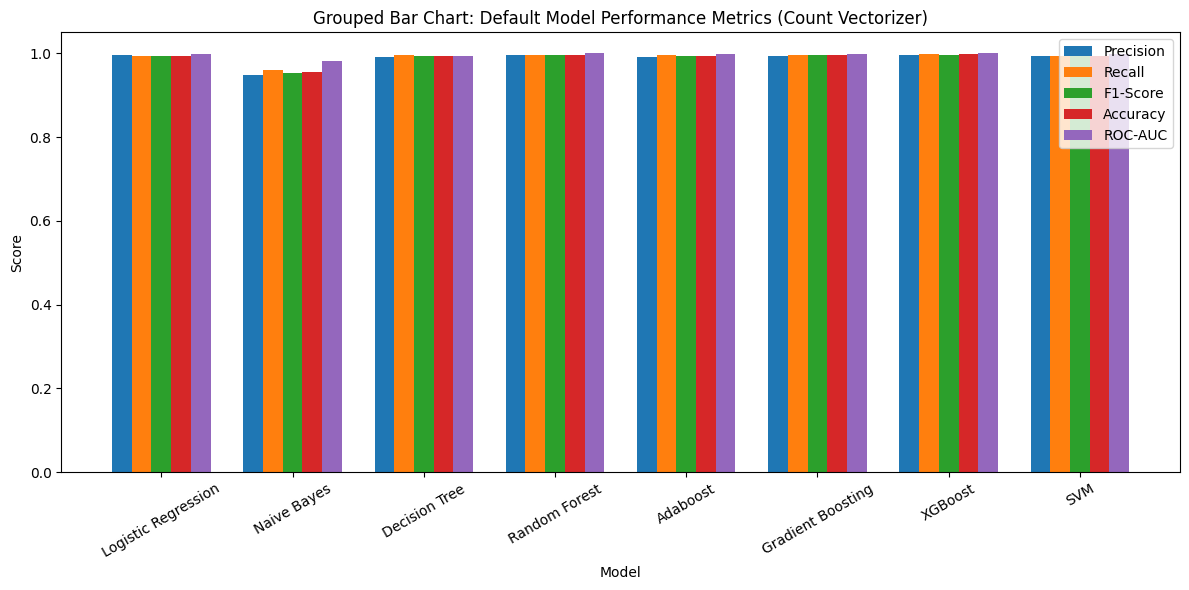

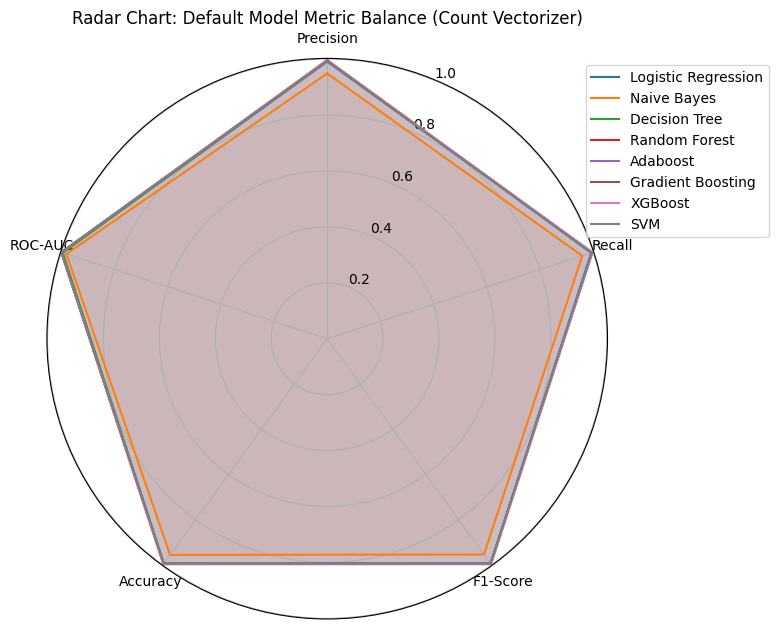

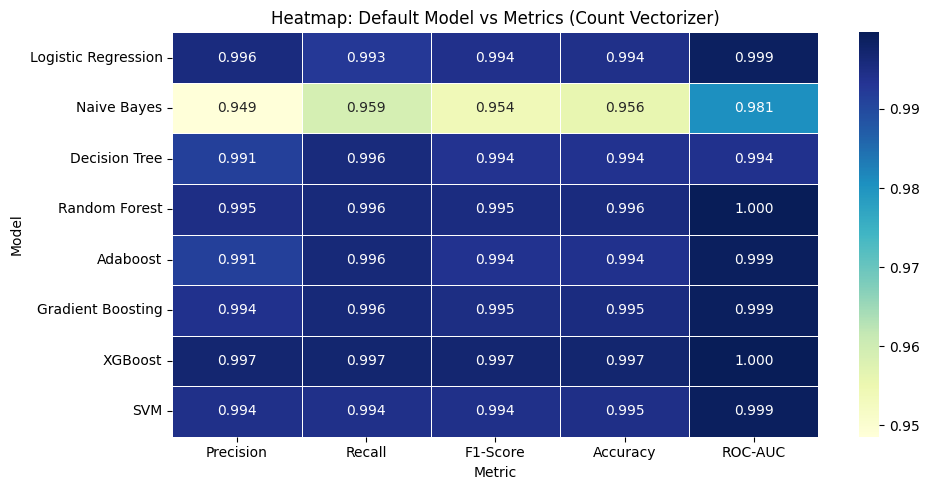

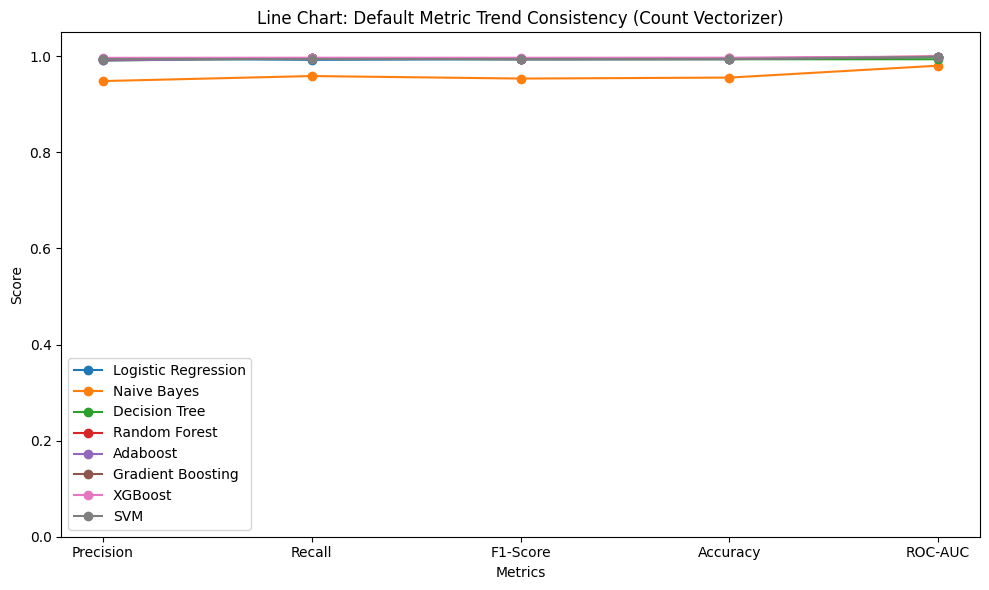

/tmp/ipykernel_144211/1727964156.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Mean_Score', y=model_col, data=ranking_df_default, palette="viridis")


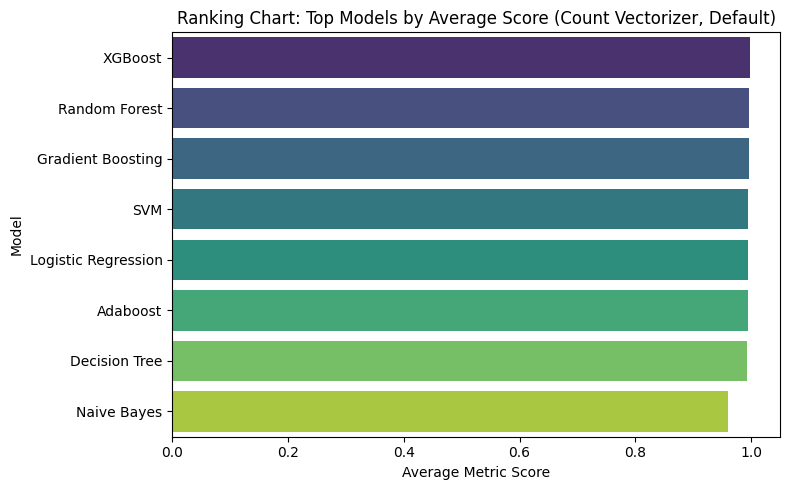

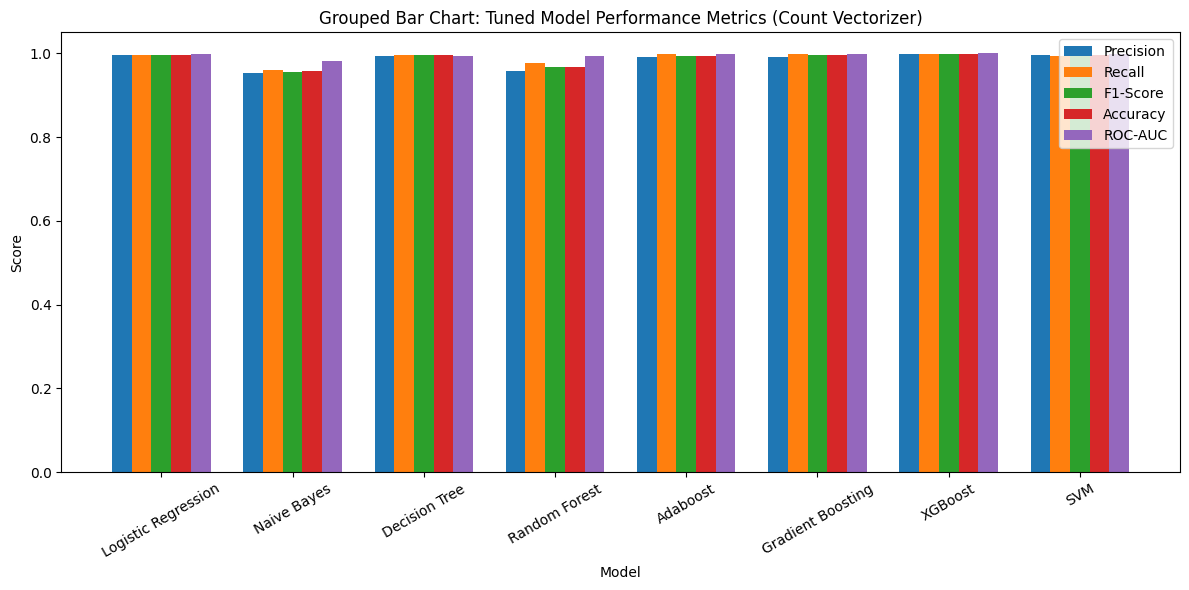

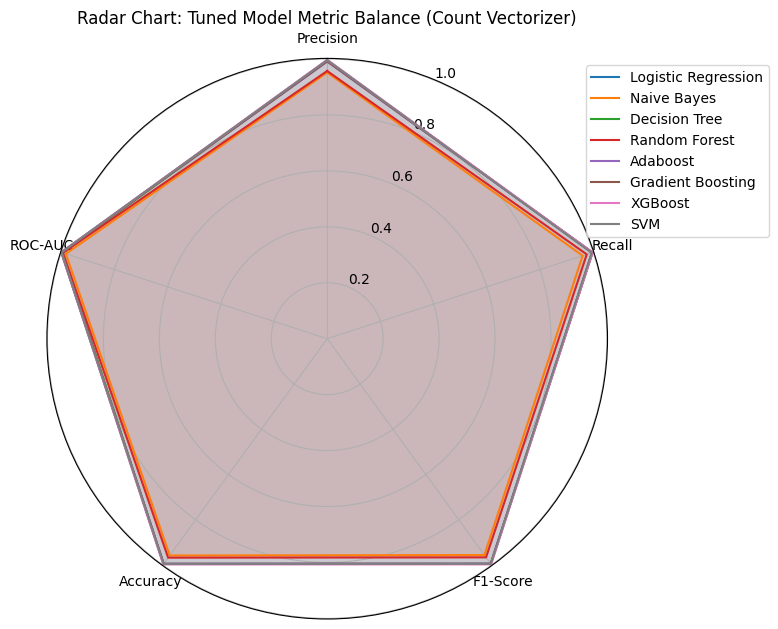

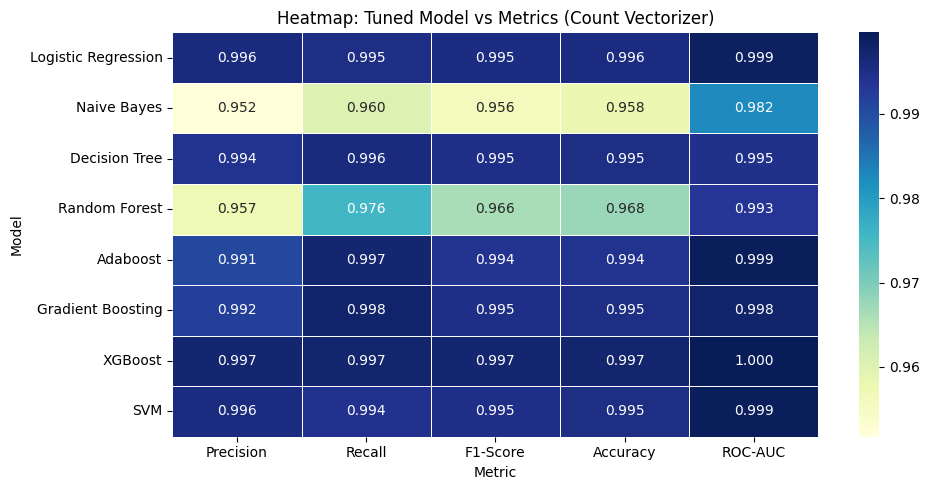

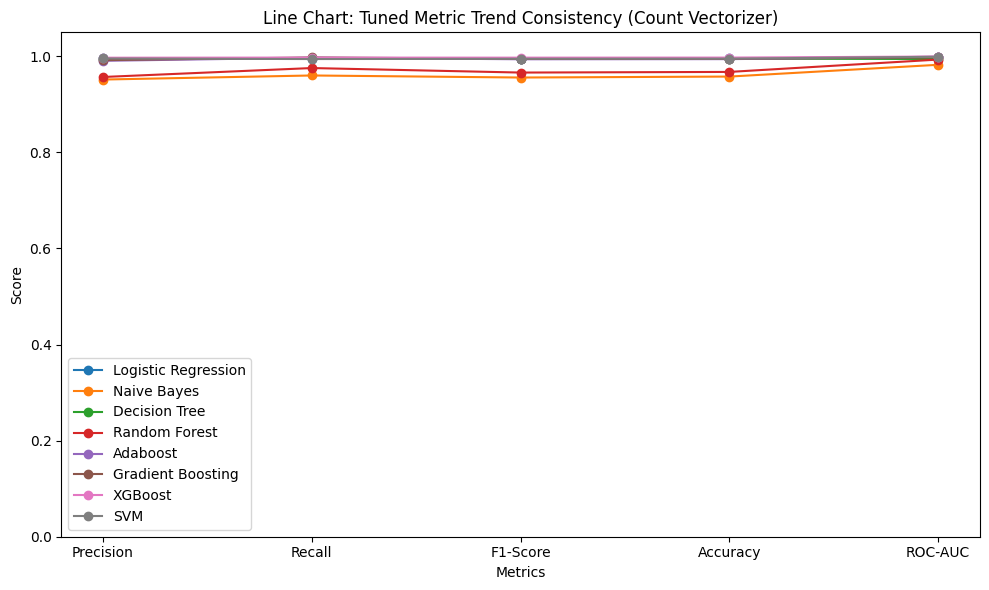

/tmp/ipykernel_144211/1727964156.py:196: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Mean_Score', y=model_col, data=ranking_df_tuned, palette="viridis")


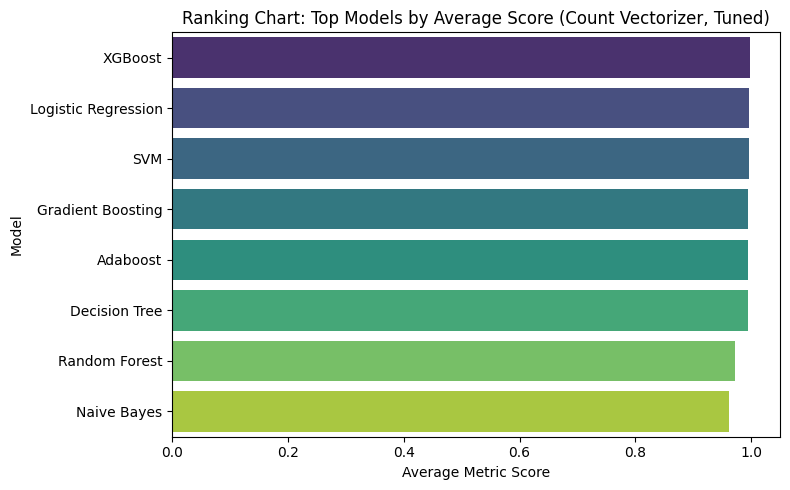

/tmp/ipykernel_144211/1727964156.py:235: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


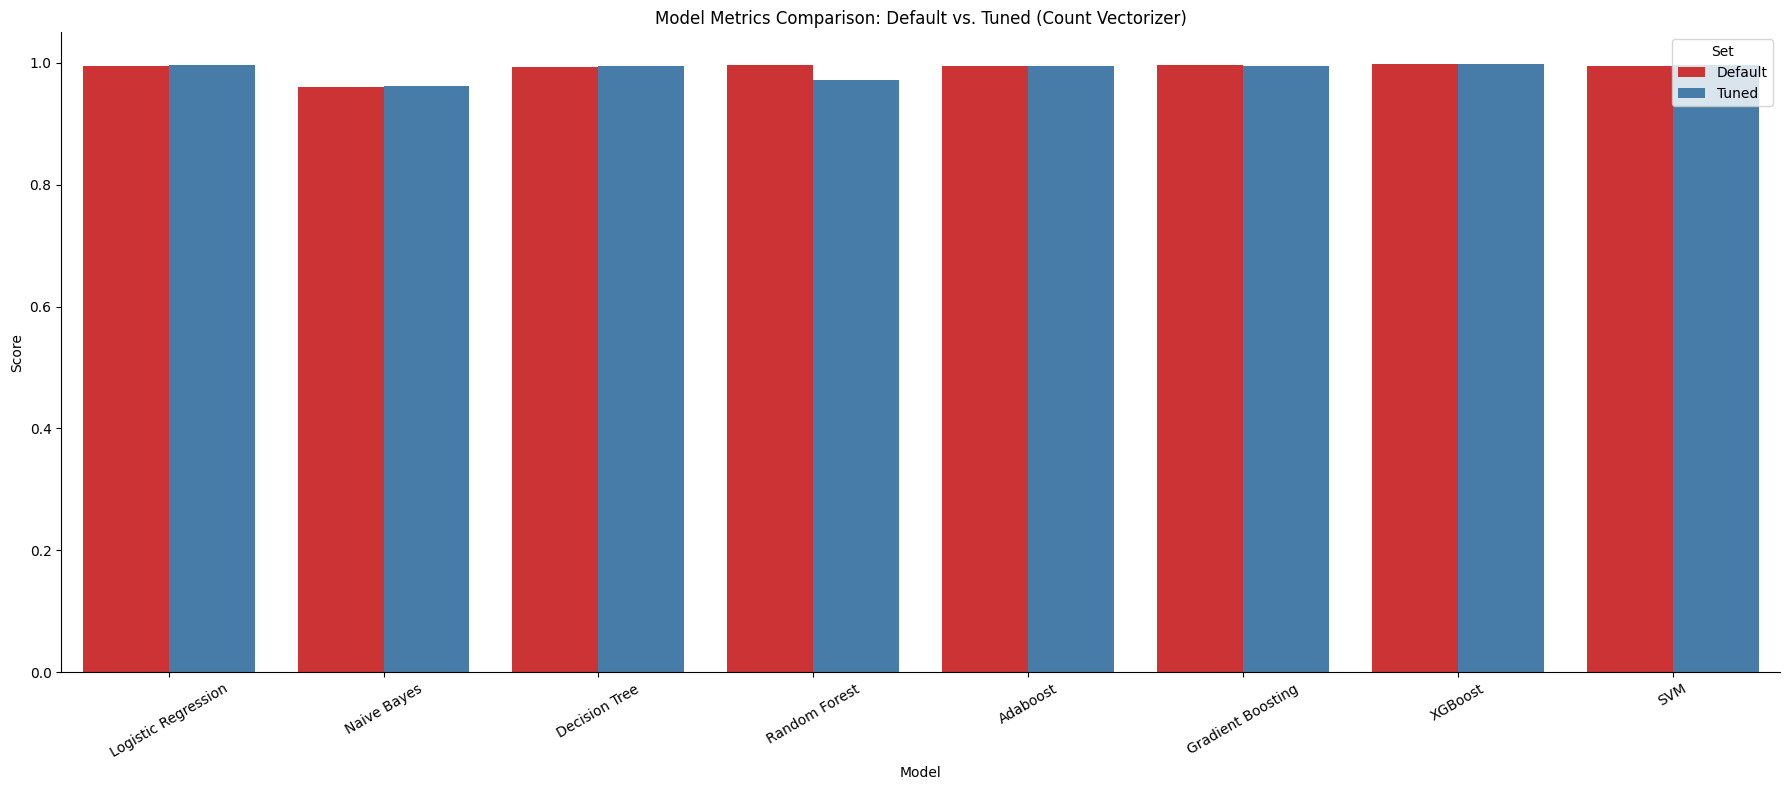

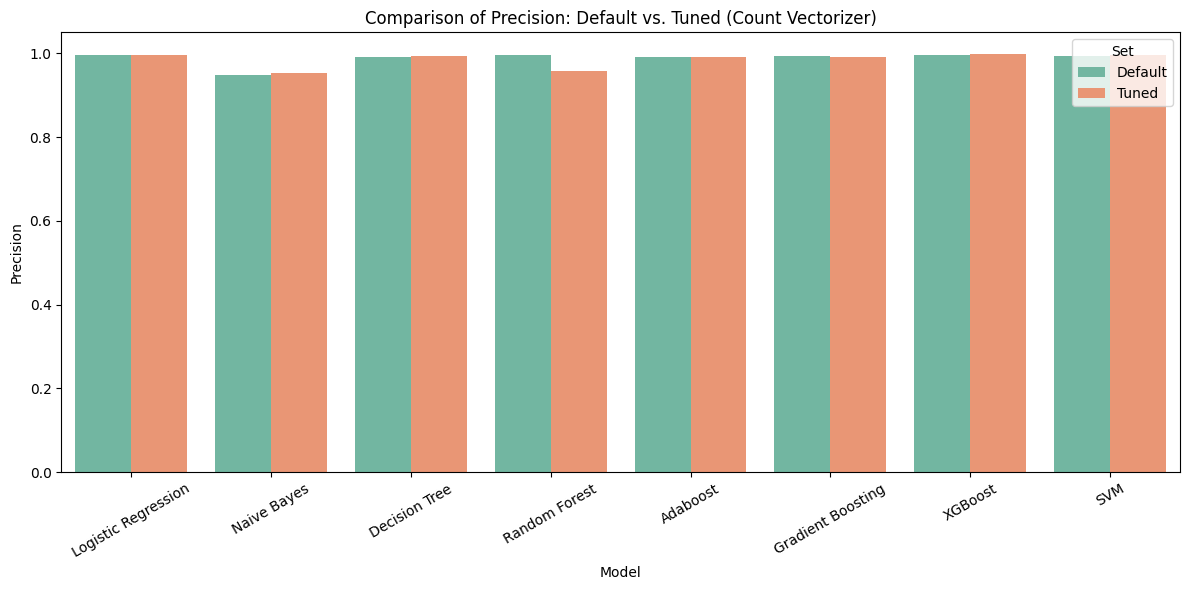

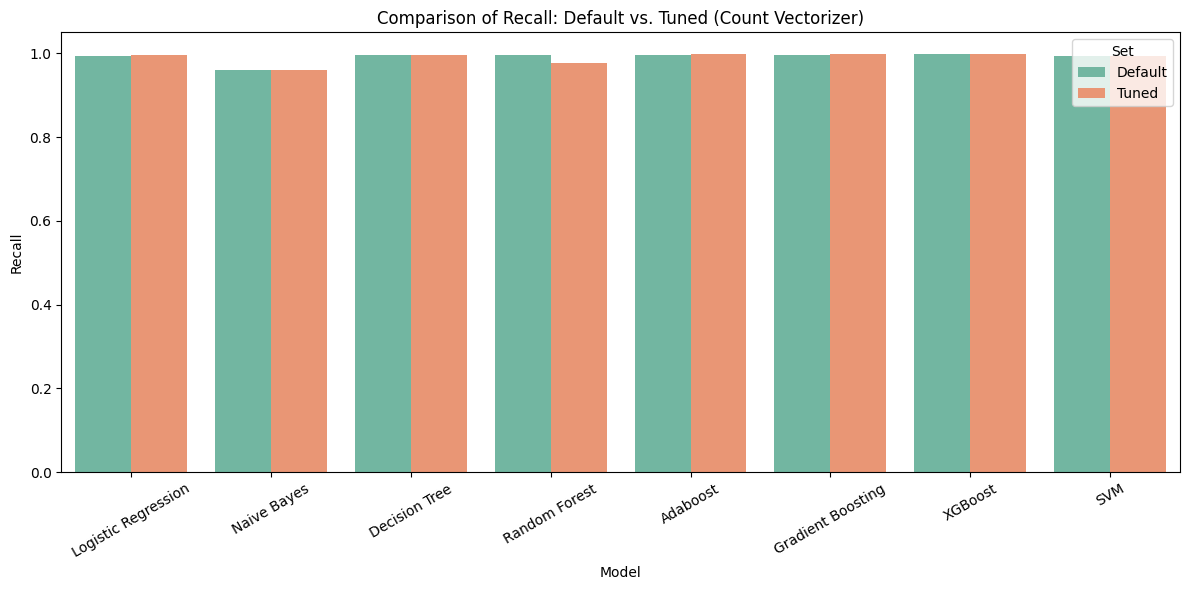

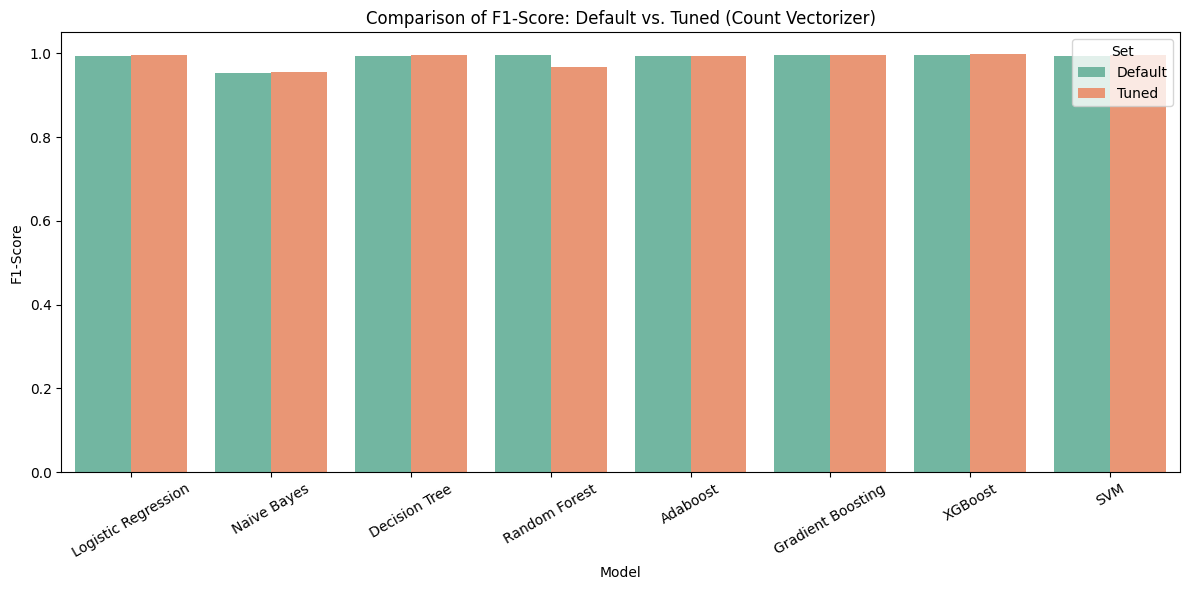

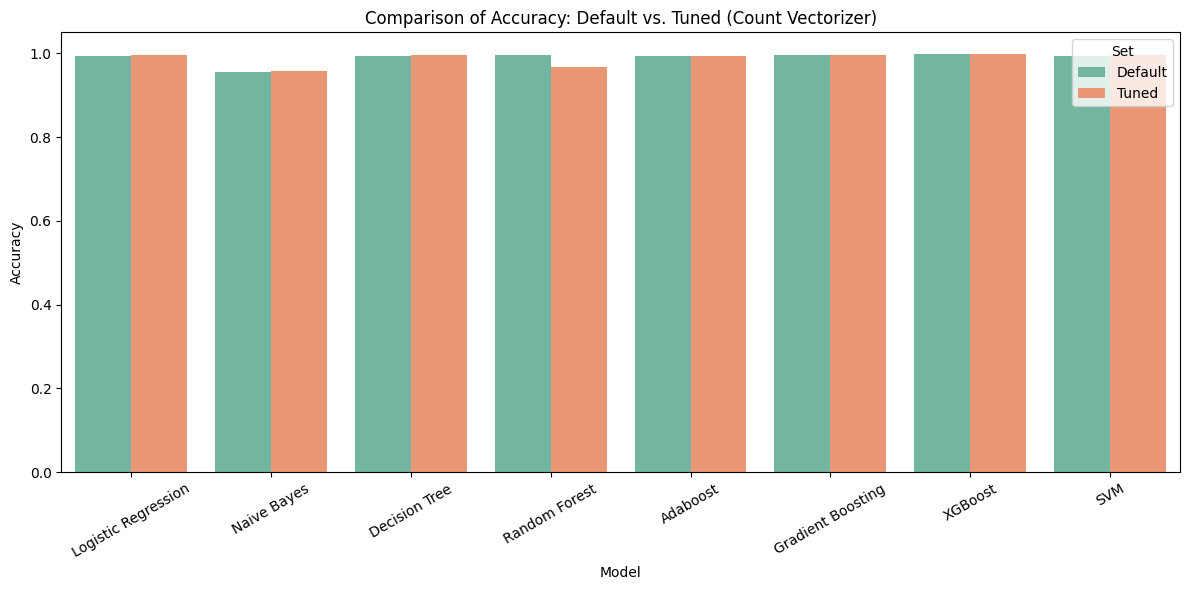

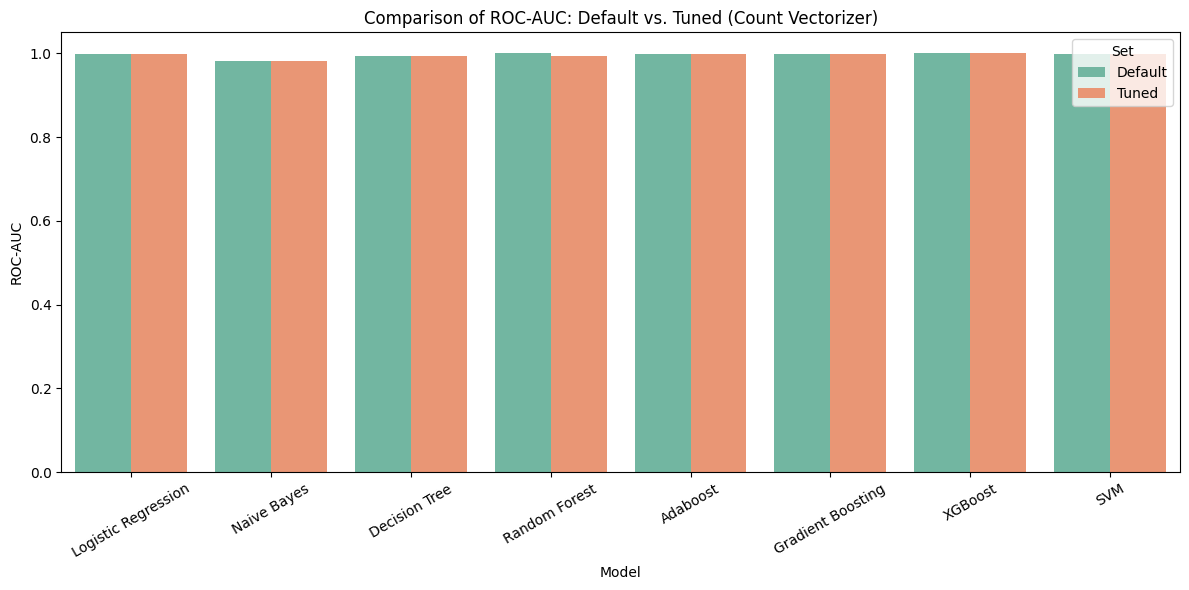

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# Paths and Configurations
# ==============================
# Input CSVs
default_csv_path = "/home/root495/Inexture/Fake New Detection/data/result/count_vectorization_default_metrics.csv"
tuned_csv_path   = "/home/root495/Inexture/Fake New Detection/data/result/count_vectorization_tuned_metrics.csv"

# Output graph directory (as instructed)
graph_dir = "/home/root495/Inexture/Fake New Detection/data/result/graph/count_vectorizer"
os.makedirs(graph_dir, exist_ok=True)

# Metric and label columns
model_col = "Model"
# The ROC-AUC metric is named literally "ROC-AUC" in the CSVs
roc_auc_col = "ROC-AUC"

# Compose the metric column lists for each DataFrame accordingly
base_metric_cols = ["Precision", "Recall", "F1-Score", "Accuracy"]
metric_cols_default = [col for col in base_metric_cols] + [roc_auc_col]
metric_cols_tuned   = [col for col in base_metric_cols] + [roc_auc_col]

default_df = pd.read_csv(default_csv_path)
tuned_df = pd.read_csv(tuned_csv_path)

# Ensure all metric columns are numeric (for robust plotting)
for df, metric_cols in zip([default_df, tuned_df], [metric_cols_default, metric_cols_tuned]):
    for col in metric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# ==============================
# Plot: Default Models
# ==============================
models = default_df[model_col].tolist()
metrics = default_df[metric_cols_default]

# ----------- Grouped Bar Chart: DEFAULT -----------
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.15
index = np.arange(len(models))
for i, metric in enumerate(metric_cols_default):
    plt.bar(index + i*bar_width, metrics[metric], bar_width, label=metric)
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Grouped Bar Chart: Default Model Performance Metrics (Count Vectorizer)')
plt.xticks(index + bar_width*2, models, rotation=30)
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
grouped_bar_path = os.path.join(graph_dir, "grouped_bar_chart_countvectorizer_default.png")
plt.savefig(grouped_bar_path)
plt.show()

# ----------- Radar Chart: DEFAULT -----------
num_vars = len(metric_cols_default)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for i, row in default_df.iterrows():
    values = row[metric_cols_default].tolist()
    values += values[:1]
    ax.plot(angles, values, label=row[model_col])
    ax.fill(angles, values, alpha=0.08)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), metric_cols_default)
plt.title("Radar Chart: Default Model Metric Balance (Count Vectorizer)")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.tight_layout()
radar_path = os.path.join(graph_dir, "radar_chart_countvectorizer_default.png")
plt.savefig(radar_path)
plt.show()

# ----------- Heatmap: DEFAULT -----------
plt.figure(figsize=(10, 5))
heatmap_data = metrics.copy()
heatmap_data.index = models
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".3f", linewidths=0.5)
plt.title('Heatmap: Default Model vs Metrics (Count Vectorizer)')
plt.ylabel('Model')
plt.xlabel('Metric')
plt.tight_layout()
heatmap_path = os.path.join(graph_dir, "heatmap_countvectorizer_default.png")
plt.savefig(heatmap_path)
plt.show()

# ----------- Line Chart: DEFAULT -----------
plt.figure(figsize=(10, 6))
for m in models:
    row = default_df[default_df[model_col] == m]
    plt.plot(metric_cols_default, row[metric_cols_default].values[0], marker='o', label=m)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Line Chart: Default Metric Trend Consistency (Count Vectorizer)')
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
line_chart_path = os.path.join(graph_dir, "line_chart_countvectorizer_default.png")
plt.savefig(line_chart_path)
plt.show()

# ----------- Ranking Chart: DEFAULT -----------
default_df['Mean_Score'] = default_df[metric_cols_default].mean(axis=1)
ranking_df_default = default_df.sort_values('Mean_Score', ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(x='Mean_Score', y=model_col, data=ranking_df_default, palette="viridis")
plt.xlabel('Average Metric Score')
plt.ylabel('Model')
plt.title('Ranking Chart: Top Models by Average Score (Count Vectorizer, Default)')
plt.xlim(0, 1.05)
plt.tight_layout()
ranking_chart_path = os.path.join(graph_dir, "ranking_chart_countvectorizer_default.png")
plt.savefig(ranking_chart_path)
plt.show()

# ==============================
# Plot: Tuned Models
# ==============================
models_tuned = tuned_df[model_col].tolist()
metrics_tuned = tuned_df[metric_cols_tuned]

# ----------- Grouped Bar Chart: TUNED -----------
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.15
index = np.arange(len(models_tuned))
for i, metric in enumerate(metric_cols_tuned):
    plt.bar(index + i*bar_width, metrics_tuned[metric], bar_width, label=metric)
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Grouped Bar Chart: Tuned Model Performance Metrics (Count Vectorizer)')
plt.xticks(index + bar_width*2, models_tuned, rotation=30)
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
grouped_bar_path_tuned = os.path.join(graph_dir, "grouped_bar_chart_countvectorizer_tuned.png")
plt.savefig(grouped_bar_path_tuned)
plt.show()

# ----------- Radar Chart: TUNED -----------
num_vars = len(metric_cols_tuned)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for i, row in tuned_df.iterrows():
    values = row[metric_cols_tuned].tolist()
    values += values[:1]
    ax.plot(angles, values, label=row[model_col])
    ax.fill(angles, values, alpha=0.08)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), metric_cols_tuned)
plt.title("Radar Chart: Tuned Model Metric Balance (Count Vectorizer)")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.tight_layout()
radar_path_tuned = os.path.join(graph_dir, "radar_chart_countvectorizer_tuned.png")
plt.savefig(radar_path_tuned)
plt.show()

# ----------- Heatmap: TUNED -----------
plt.figure(figsize=(10, 5))
heatmap_data_tuned = metrics_tuned.copy()
heatmap_data_tuned.index = models_tuned
sns.heatmap(heatmap_data_tuned, annot=True, cmap="YlGnBu", fmt=".3f", linewidths=0.5)
plt.title('Heatmap: Tuned Model vs Metrics (Count Vectorizer)')
plt.ylabel('Model')
plt.xlabel('Metric')
plt.tight_layout()
heatmap_path_tuned = os.path.join(graph_dir, "heatmap_countvectorizer_tuned.png")
plt.savefig(heatmap_path_tuned)
plt.show()

# ----------- Line Chart: TUNED -----------
plt.figure(figsize=(10, 6))
for m in models_tuned:
    row = tuned_df[tuned_df[model_col] == m]
    plt.plot(metric_cols_tuned, row[metric_cols_tuned].values[0], marker='o', label=m)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Line Chart: Tuned Metric Trend Consistency (Count Vectorizer)')
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
line_chart_path_tuned = os.path.join(graph_dir, "line_chart_countvectorizer_tuned.png")
plt.savefig(line_chart_path_tuned)
plt.show()

# ----------- Ranking Chart: TUNED -----------
tuned_df['Mean_Score'] = tuned_df[metric_cols_tuned].mean(axis=1)
ranking_df_tuned = tuned_df.sort_values('Mean_Score', ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(x='Mean_Score', y=model_col, data=ranking_df_tuned, palette="viridis")
plt.xlabel('Average Metric Score')
plt.ylabel('Model')
plt.title('Ranking Chart: Top Models by Average Score (Count Vectorizer, Tuned)')
plt.xlim(0, 1.05)
plt.tight_layout()
ranking_chart_path_tuned = os.path.join(graph_dir, "ranking_chart_countvectorizer_tuned.png")
plt.savefig(ranking_chart_path_tuned)
plt.show()

# ==============================
# COMPARISON PLOT: Default vs. Tuned
# ==============================
# For the purposes of comparison, map to a unified name (for e.g., always as 'ROC-AUC')
metric_col_map = {name: name for name in base_metric_cols}
metric_col_map[roc_auc_col] = "ROC-AUC"

compare_default_df = default_df[[model_col] + metric_cols_default].copy().rename(columns=metric_col_map)
compare_tuned_df = tuned_df[[model_col] + metric_cols_tuned].copy().rename(columns=metric_col_map)

compare_default_df['Set'] = 'Default'
compare_tuned_df['Set'] = 'Tuned'
metric_cols_compare = base_metric_cols + ["ROC-AUC"]

compare_df = pd.concat([
    compare_default_df[[model_col, "Set"] + metric_cols_compare], 
    compare_tuned_df[[model_col, "Set"] + metric_cols_compare]
], ignore_index=True)

# Melt for grouped barplot
melted_compare = compare_df.melt(
    id_vars=[model_col, "Set"], 
    value_vars=metric_cols_compare, 
    var_name='Metric', 
    value_name='Score'
)

plt.figure(figsize=(18, 8))
# We'll do a grouped bar by metric
sns.barplot(
    data=melted_compare, 
    x='Model', y='Score', 
    hue='Set', 
    ci=None, 
    palette='Set1',
    errorbar=None
)
sns.despine()
plt.subplots_adjust(top=0.85)
plt.title("Model Metrics Comparison: Default vs. Tuned (Count Vectorizer)")
plt.ylim(0, 1.05)
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=30)
comparison_graph_path = os.path.join(graph_dir, "comparison_bar_chart_countvectorizer_default_vs_tuned.png")
plt.tight_layout()
plt.savefig(comparison_graph_path)
plt.show()

# Also, comparison as a grouped bar for each metric
for metric in metric_cols_compare:
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=melted_compare[melted_compare["Metric"] == metric],
        x='Model', y='Score', hue='Set', palette='Set2',
        errorbar=None
    )
    plt.ylim(0, 1.05)
    plt.title(f"Comparison of {metric}: Default vs. Tuned (Count Vectorizer)")
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.xticks(rotation=30)
    plt.tight_layout()
    metric_path = os.path.join(graph_dir, f"comparison_bar_{metric.lower().replace('-', '_')}_default_vs_tuned.png")
    plt.savefig(metric_path)
    plt.show()


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from math import pi

# Set matplotlib backend for safety in non-interactive environments
import matplotlib
matplotlib.use('Agg')

# Paths to data and graph directory
base_dir = "/home/root495/Inexture/Fake New Detection/data/result"
comparison_graph_dir = os.path.join(base_dir, "graph", "comparison")
os.makedirs(comparison_graph_dir, exist_ok=True)

# File paths
paths = {
    "CountVectorizer Default": os.path.join(base_dir, "count_vectorization_default_metrics.csv"),
    "CountVectorizer Tuned": os.path.join(base_dir, "count_vectorization_tuned_metrics.csv"),
    "TFIDF Default": os.path.join(base_dir, "TFIDF_default_metrics.csv"),
    "TFIDF Tuned": os.path.join(base_dir, "TFIDF_tuned_metrics.csv"),
}

# Metric columns expected for display (these must appear in the same way in full_df for plotting)
metric_cols = ["Precision", "Recall", "F1-Score", "Accuracy", "ROC-AUC"]
model_col = "Model"
feature_set_col = "Feature Set"
setting_col = "Setting"

# Helper: find most likely ROC-AUC column, and map all metric column names
def canonicalize_metrics(df, metric_cols_required):
    # Build mapping from possible variants to canonical names
    canonical_names = {
        "Precision": "Precision",
        "Recall": "Recall",
        "F1-Score": "F1-Score",
        "F1_Score": "F1-Score",
        "F1 Score": "F1-Score",
        "F1Score": "F1-Score",
        "Accuracy": "Accuracy",
        "ROC-AUC": "ROC-AUC",
        "ROC_AUC": "ROC-AUC",
        "ROC - AUC": "ROC-AUC",
        "AUC": "ROC-AUC",
        "ROC_AUC_SCORE": "ROC-AUC",
        "ROC_AUC-Score": "ROC-AUC",
        "ROC AUC": "ROC-AUC",
        "ROC AUC Score": "ROC-AUC",
        "roc_auc": "ROC-AUC",
        "roc-auc": "ROC-AUC",
    }
    rename_map = {}
    found_metrics = set()
    for col in df.columns:
        key = col.replace(" ", "").replace("-", "_").upper()
        # handle ROC first (since it's the primary cause of mismatches)
        if "ROC" in key and "AUC" in key:
            rename_map[col] = "ROC-AUC"
            found_metrics.add("ROC-AUC")
            continue
        # Try simple direct match
        stripped_col = col.strip().replace(" ", "").replace("-", "").replace("_", "").lower()
        for k, v in canonical_names.items():
            stripped_key = k.strip().replace(" ", "").replace("-", "").replace("_", "").lower()
            if stripped_col == stripped_key:
                rename_map[col] = v
                found_metrics.add(v)
                break
    # Apply renaming
    df = df.rename(columns=rename_map)
    # Fill any missing required metric with NaN
    for target in metric_cols_required:
        if target not in df.columns:
            df[target] = np.nan
    return df

# --- Load and Concatenate Data ---
all_dfs = []
for (setting, path) in paths.items():
    df = pd.read_csv(path)
    df = canonicalize_metrics(df, metric_cols)
    # Insert columns for plotting
    featureset = "TFIDF" if "TFIDF" in setting else "CountVectorizer"
    default_or_tuned = "Default" if "Default" in setting else "Tuned"
    df[feature_set_col] = featureset
    df[setting_col] = default_or_tuned
    # Ensure float type for metrics (skip if column doesn't exist)
    for m in metric_cols:
        if m in df.columns:
            df[m] = pd.to_numeric(df[m], errors='coerce')
        else:
            df[m] = np.nan
    all_dfs.append(df)

full_df = pd.concat(all_dfs, ignore_index=True)

# Melted for many tasks
melted = full_df.melt(
    id_vars=[feature_set_col, setting_col, model_col],
    value_vars=metric_cols,
    var_name='Metric',
    value_name='Score'
)

# Sort for consistency
melted[feature_set_col] = pd.Categorical(melted[feature_set_col], ["CountVectorizer", "TFIDF"])
melted[setting_col] = pd.Categorical(melted[setting_col], ["Default", "Tuned"])

# ---------- 1. Grouped bar chart: All in one by (Feature, Setting) ----------
plt.figure(figsize=(18, 8))
sns.barplot(
    data=melted,
    x='Metric',
    y='Score',
    hue=feature_set_col,
    hue_order=["CountVectorizer", "TFIDF"],
    ci=None,
    dodge=True
)
plt.title("Grouped Bar Chart by Feature Set (All Models & Settings)")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.ylim(0, 1.05)
plt.legend(title='Feature Set')
plt.tight_layout()
plt.savefig(os.path.join(comparison_graph_dir, "grouped_bar_chart_feature_set.png"))
plt.close()

# Now Grouped by Setting
plt.figure(figsize=(18, 8))
sns.barplot(
    data=melted,
    x='Metric',
    y='Score',
    hue=setting_col,
    ci=None,
    dodge=True
)
plt.title("Grouped Bar Chart by Setting (All Models & Feature Sets)")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.ylim(0, 1.05)
plt.legend(title='Setting')
plt.tight_layout()
plt.savefig(os.path.join(comparison_graph_dir, "grouped_bar_chart_setting.png"))
plt.close()

# Grouped: Both Feature Set and Setting (each pair a color)
melted['Feature_Set+Setting'] = melted[feature_set_col].astype(str) + " " + melted[setting_col].astype(str)
plt.figure(figsize=(20, 8))
sns.barplot(
    data=melted,
    x='Metric',
    y='Score',
    hue='Feature_Set+Setting',
    ci=None,
    dodge=True
)
plt.title("Grouped Bar Chart: Feature Set + Setting Comparison (All Models)")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.ylim(0, 1.05)
plt.legend(title='Feature Set + Setting')
plt.tight_layout()
plt.savefig(os.path.join(comparison_graph_dir, "grouped_bar_chart_feature_setting_combo.png"))
plt.close()

# --------- 2. For Each Model: Per-metric grouped bar (Feature Set + Setting) -----------
for mdl in full_df[model_col].unique():
    plt.figure(figsize=(12, 6))
    local = melted[melted[model_col] == mdl]
    sns.barplot(
        data=local,
        x='Metric',
        y='Score',
        hue='Feature_Set+Setting',
        ci=None,
        dodge=True
    )
    plt.title(f"Model Comparison: {mdl}")
    plt.ylabel("Score")
    plt.xlabel("Metric")
    plt.ylim(0, 1.05)
    plt.legend(title='Feature Set + Setting')
    plt.tight_layout()
    plt.savefig(os.path.join(comparison_graph_dir, f"grouped_bar_chart_{mdl.replace(' ', '_').lower()}_all_combos.png"))
    plt.close()

# -------- 3. For Each Metric: Per-model grouped bar (Feature Set + Setting) -------
for met in metric_cols:
    plt.figure(figsize=(14, 6))
    local = melted[melted['Metric'] == met]
    sns.barplot(
        data=local,
        x=model_col,
        y='Score',
        hue='Feature_Set+Setting',
        ci=None,
        dodge=True
    )
    plt.title(f"Metric Comparison by Model: {met}")
    plt.ylabel("Score")
    plt.xlabel("Model")
    plt.ylim(0, 1.05)
    plt.legend(title='Feature Set + Setting')
    plt.tight_layout()
    plt.savefig(os.path.join(comparison_graph_dir, f"grouped_bar_chart_allmodels_{met.replace('-', '_').lower()}_all_combos.png"))
    plt.close()

# -------- 4. Per-Model Radar Charts (show all 4 combos per model) ----------
def plot_radar_chart_rich(scores_by_combo, metrics, combo_labels, model_name, filename):
    N = len(metrics)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))
    color_map = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    for idx, arr in enumerate(scores_by_combo):
        vals = arr.tolist()
        vals += vals[:1]
        ax.plot(angles, vals, linewidth=2, linestyle='solid', label=combo_labels[idx], color=color_map[idx % len(color_map)])
        ax.fill(angles, vals, alpha=0.10, color=color_map[idx % len(color_map)])
    ax.set_theta_offset(pi/2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids([a * 180/pi for a in angles[:-1]], metrics)
    ax.set_ylim(0, 1.05)
    plt.title(f'Radar Chart: {model_name} (All Feature/Setting Combos)')
    ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1.15))
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

for mdl in full_df[model_col].unique():
    scores_by_combo = []
    combo_labels = []
    for featureset in ["CountVectorizer", "TFIDF"]:
        for setting in ["Default", "Tuned"]:
            local_row = full_df[(full_df[model_col] == mdl) & (full_df[feature_set_col] == featureset) & (full_df[setting_col] == setting)]
            if local_row.empty:
                vals = np.zeros(len(metric_cols))
            else:
                # Make a copy to avoid KeyError
                vals = np.array([local_row[m].iloc[0] if m in local_row.columns else np.nan for m in metric_cols], dtype=float)
            scores_by_combo.append(vals)
            combo_labels.append(f"{featureset} {setting}")
    outpath = os.path.join(comparison_graph_dir, f"radar_chart_{mdl.replace(' ', '_').lower()}_all_combos.png")
    plot_radar_chart_rich(scores_by_combo, metric_cols, combo_labels, mdl, outpath)

# -------- 5. Heatmap: Model/Feature/Setting per metric ---------
heatmap_data = []
heatmap_labels = []
for featureset in ["CountVectorizer", "TFIDF"]:
    for setting in ["Default", "Tuned"]:
        local = full_df[(full_df[feature_set_col] == featureset) & (full_df[setting_col] == setting)]
        for idx, row in local.iterrows():
            vals = []
            for m in metric_cols:
                vals.append(row[m] if m in row else np.nan)
            heatmap_data.append(vals)
            heatmap_labels.append(f"{featureset} {setting} | {row[model_col]}")

heatmap_matrix = np.array(heatmap_data, dtype=np.float64)
plt.figure(figsize=(15, len(heatmap_labels)*0.55+3))
sns.heatmap(
    heatmap_matrix, annot=True, cmap="crest",
    xticklabels=metric_cols, yticklabels=heatmap_labels,
    vmin=0, vmax=1, fmt=".3f", linewidths=0.5
)
plt.title('Heatmap: (Feature, Setting, Model) x Metrics')
plt.ylabel('Feature Set, Setting | Model')
plt.xlabel('Metric')
plt.tight_layout()
plt.savefig(os.path.join(comparison_graph_dir, "comparison_heatmap.png"))
plt.close()

# -------- 6. Difference Bar Charts: Quantify improvement tuning, method, etc ---------
# (a) For each model+featureset, show "Tuned - Default" per metric
for featureset in ["CountVectorizer", "TFIDF"]:
    diffs = []
    labels = []
    for mdl in full_df[model_col].unique():
        try:
            tuned_row = full_df[(full_df[model_col]==mdl) & (full_df[feature_set_col]==featureset) & (full_df[setting_col]=="Tuned")]
            default_row = full_df[(full_df[model_col]==mdl) & (full_df[feature_set_col]==featureset) & (full_df[setting_col]=="Default")]
            tuned = np.array([tuned_row[m].iloc[0] if m in tuned_row.columns and not tuned_row.empty else np.nan for m in metric_cols], dtype=float)
            default = np.array([default_row[m].iloc[0] if m in default_row.columns and not default_row.empty else np.nan for m in metric_cols], dtype=float)
        except Exception:
            tuned = default = np.zeros(len(metric_cols))
        diffs.append(tuned - default)
        labels.append(mdl)
    diffs_df = pd.DataFrame(diffs, columns=metric_cols)
    diffs_df[model_col] = labels
    diffs_melted = diffs_df.melt(id_vars=[model_col], value_vars=metric_cols, var_name='Metric', value_name='Score Improvement')
    plt.figure(figsize=(12, 6))
    sns.barplot(data=diffs_melted, x='Metric', y='Score Improvement', hue=model_col, palette='tab10', dodge=True)
    plt.axhline(0, color='k', linestyle='--')
    plt.title(f"Difference Bar Chart: {featureset} (Tuned - Default) per Metric")
    plt.tight_layout()
    plt.savefig(os.path.join(comparison_graph_dir, f"diff_bar_chart_{featureset.lower()}_tuned_vs_default.png"))
    plt.close()

# (b) For each model+setting, show "TFIDF - CountVectorizer"
for setting in ["Default", "Tuned"]:
    diffs = []
    labels = []
    for mdl in full_df[model_col].unique():
        try:
            tfidf_row = full_df[(full_df[model_col]==mdl) & (full_df[feature_set_col]=="TFIDF") & (full_df[setting_col]==setting)]
            countvec_row = full_df[(full_df[model_col]==mdl) & (full_df[feature_set_col]=="CountVectorizer") & (full_df[setting_col]==setting)]
            tfidf = np.array([tfidf_row[m].iloc[0] if m in tfidf_row.columns and not tfidf_row.empty else np.nan for m in metric_cols], dtype=float)
            countvec = np.array([countvec_row[m].iloc[0] if m in countvec_row.columns and not countvec_row.empty else np.nan for m in metric_cols], dtype=float)
        except Exception:
            tfidf = countvec = np.zeros(len(metric_cols))
        diffs.append(tfidf - countvec)
        labels.append(mdl)
    diffs_df = pd.DataFrame(diffs, columns=metric_cols)
    diffs_df[model_col] = labels
    diffs_melted = diffs_df.melt(id_vars=[model_col], value_vars=metric_cols, var_name='Metric', value_name='Score Improvement')
    plt.figure(figsize=(12, 6))
    sns.barplot(data=diffs_melted, x='Metric', y='Score Improvement', hue=model_col, palette='tab10', dodge=True)
    plt.axhline(0, color='k', linestyle='--')
    plt.title(f"Difference Bar Chart: {setting} (TFIDF - CountVectorizer) per Metric")
    plt.tight_layout()
    plt.savefig(os.path.join(comparison_graph_dir, f"diff_bar_chart_tfidf_vs_countvectorizer_{setting.lower()}.png"))
    plt.close()

# -------- 7. Overall Ranking Chart ---------
full_df['Mean_Score'] = full_df[[m for m in metric_cols if m in full_df.columns]].mean(axis=1)
ranked = full_df.sort_values('Mean_Score', ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(
    data=ranked,
    x='Mean_Score',
    y=ranked.apply(lambda r: f"{r[feature_set_col]} {r[setting_col]} | {r[model_col]}", axis=1),
    palette='viridis'
)
plt.xlabel('Mean Metric Score')
plt.ylabel('Feature | Setting | Model')
plt.title('Overall Ranking: Top Model/Feature Set/Setting Combinations')
plt.xlim(0, 1.05)
plt.tight_layout()
plt.savefig(os.path.join(comparison_graph_dir, "overall_ranking_chart.png"))
plt.close()


/tmp/ipykernel_144211/1219179407.py:112: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_144211/1219179407.py:132: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_144211/1219179407.py:152: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_144211/1219179407.py:173: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_144211/1219179407.py:173: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_144211/1219179407.py:173: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_144211/1219179407.py:173: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=